# Capstone Project - The Battle of Neighborhoods

# Introduction

This is as part of the capstone project in which each learner is required to leverage the Foursquare API to solve business problems.

## Business Problem

<img align="left" width="1000" height="300" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Hong_Kong_Victoria_Harbour_night_2004-08.jpg/800px-Hong_Kong_Victoria_Harbour_night_2004-08.jpg">

The target audience of this analysis are people who want to open a new business in catering industry in Hong Kong but have limited funds and little knowledge on catering industry.<br>
This analysis will make use of foursquare location data to help their decision.


Hong Kong is crowded with shops, buildings and people. Although it is highly populated, it is hard to maintain a business as rents incur lots of cost.  <br>
Therefore, as an important factor that affacts the number of customer, choosing a correct location is vital in store’s profitability, which is crucial to the business survival rate. <br>
So, suppose you want to open a new resturant in Hong Kong, which neighbourhood should you choose?

In this analysis, let's use coffee shop as an example as it is one of the most popular type of restaurant in Hong Kong. <br>
We will explore the catering industry in different neighbourhoods in Hong Kong

Here are several questions to answer: <br>
*Which locations have the most/least coffee shops?*<br>
*Is there a relationship between the number of nearby facilities and the number of coffee shops?* <br>
*Which other locations are similar in term of the distribution of catering businesses ?* 



#### Coffee shop
<img align="left" width="300" height="300" src="https://media.timeout.com/images/103520425/image.jpg"> 

# Data

To solve this problem, we need to use the following data and tools. 
1. The names of various neighborhoods in Hong Kong <br>
The name of communities are retrieved from the Midland Realty, a well known real estate company (https://www.midland.com.hk/).
2. Coordinates of various neighborhoods in Hong Kong <br>
We need latitude and longitude to plot different locations for visualization. <br>
They will also be used to explore the neighborhood using Foursquare api. <br>
We will use GeoPy's Nominatim to get the latitude and longitude for each neighborhood
3. Foursquare api <br>
We will utilize the Foursquare api to search the list of venues grouped by categories for each neighborhood

# Methodology

In this analysis, there are 4 main sections.
1. Data collection  <br>
Scrap the neighborhoods' names from website, perform data cleansing, prepare coordinate information   
2. Data exploration  <br>
Visualise the neighborhoods' location, search for venues, understand the data with descriptive statistics 
3. Data preparation   <br>
Prepare data for clustering algorithm
4. Modelling  <br>
Use clustering algorithm to group neighborhoods into clusters

## Data collection

#### Scraping the community names from Midland Realty
<a id='5'></a>

(https://www.midland.com.hk/)  <br>
<img align="left" width="500" height="500" src="https://i.imgur.com/2PlqD4h.png"> 


#### Import BeautifulSoup and scrap the text

In [179]:
import requests
import pandas as pd
from bs4 import BeautifulSoup as bs

url = "https://en.midland.com.hk/estate/Kowloon-20"
html = requests.get(url).text
soup = bs(html, 'html.parser')

#### Find the text after parsing

In [180]:
ta = soup.find('nav', {'id': 'districts'})
Children = ta.findChildren("a" , recursive=False)
subdistricts = []
for child in Children:
    subdistricts.append(child.text)
subdistricts

['Kowloon (1049)',
 'Tsim Sha Tsui                                      (87)',
 'Kowloon Station                                    (8)',
 'Yau Ma Tei                                         (10)',
 'Kingspark                                          (12)',
 'Mongkok                                            (105)',
 'Tai Kok Tsui                                       (36)',
 'Olympic                                            (11)',
 'Lai Chi Kok                                        (8)',
 'Mei Foo                                            (11)',
 'Cheung Sha Wan / Sham Shui Po                      (189)',
 'Yau Yat Chuen                                      (35)',
 'Kowloon Tong / Beacon Hill                         (72)',
 'Ho Man Tin                                         (130)',
 'Hung Hom                                           (55)',
 'To Kwa Wan                                         (68)',
 'Kai Tak                                            (7)',
 'Kowloon City       

#### Convert the list into data frame and display the first few rows

In [181]:
Kowloon_Location = pd.DataFrame({'District': subdistricts[0],'neighborhood': subdistricts[1:]})
Kowloon_Location.head()

,District,neighborhood
0,Kowloon (1049),Tsim Sha Tsui ...
1,Kowloon (1049),Kowloon Station ...
2,Kowloon (1049),Yau Ma Tei ...
3,Kowloon (1049),Kingspark ...
4,Kowloon (1049),Mongkok ...


#### Repeat above for Hong Kong Island and concate the dataframe

In [182]:
url = "https://en.midland.com.hk/estate/Hong-Kong-10"
html = requests.get(url).text
soup2 = bs(html, 'html.parser')
soup2
ta = soup2.find('nav', {'id': 'districts'})
Children = ta.findChildren("a" , recursive=False)
subdistricts = []
for child in Children:
    subdistricts.append(child.text)
subdistricts
HK_Island_Location = pd.DataFrame({'District': subdistricts[0],'neighborhood': subdistricts[1:]})
print(HK_Island_Location.head())

HK_Location = pd.concat([Kowloon_Location, HK_Island_Location],ignore_index=True)

           District                                       neighborhood
0  Hong Kong (1397)  Chai Wan                                      ...
1  Hong Kong (1397)  Heng Fa Chuen (Chai Wan)                      ...
2  Hong Kong (1397)  Shau Kei Wan                                  ...
3  Hong Kong (1397)  Sai Wan Ho / Taikoo                           ...
4  Hong Kong (1397)  Quarry Bay                                    ...


#### Remove the unwanted brackets and numbers

In [183]:
import re
def removedigit(x):
    x = re.findall("([a-zA-Z ]+.+[a-zA-Z ]+)", x)[0].strip()
    return x

HK_Location = HK_Location.applymap(removedigit)
HK_Location.head()

,District,neighborhood
0,Kowloon,Tsim Sha Tsui
1,Kowloon,Kowloon Station
2,Kowloon,Yau Ma Tei
3,Kowloon,Kingspark
4,Kowloon,Mongkok


#### Some additional adjustments...
To avoid confusion and ensure correct coordinates are produced during the search,
1. Several neighborhoods in Hong Kong have similar names - For searching purpose, I will add the district name of that neighborhood.
2. Some neighborhoods' names can be confusing, such as Kowloon station (Actually it is a metro station). I will rename them or drop them
3. For some rows, there is "/" to seperate 2 or more neighborhoods. Indeed they are different neighborhoods. I will remove the "/" and create an additional row. 

##### Split and create additional rows

In [184]:
HK_Location2 = pd.concat([pd.Series(row['District'], row['neighborhood'].split('/'))              
                    for _, row in HK_Location.iterrows()]).reset_index().rename(index=str, columns={"index": "neighborhood", 0: "District"})

HK_Location2[HK_Location2.columns] = HK_Location2.apply(lambda x: x.str.strip())
HK_Location2

,neighborhood,District
0,Tsim Sha Tsui,Kowloon
1,Kowloon Station,Kowloon
2,Yau Ma Tei,Kowloon
3,Kingspark,Kowloon
4,Mongkok,Kowloon
5,Tai Kok Tsui,Kowloon
6,Olympic,Kowloon
7,Lai Chi Kok,Kowloon
8,Mei Foo,Kowloon
9,Cheung Sha Wan,Kowloon


##### Rename neighborhood name /  Drop rows

In [185]:
HK_Location2.loc[HK_Location2.neighborhood == 'Kingspark', 'neighborhood'] = 'Kings park'
HK_Location2.loc[HK_Location2.neighborhood == 'Tseung Kwan O Station', 'neighborhood'] = 'Tseung Kwan O'
HK_Location2.loc[HK_Location2.neighborhood == 'Yau Tong', 'neighborhood'] = 'Yau Tong Station'
HK_Location2.loc[HK_Location2.neighborhood == 'Heng Fa Chuen (Chai Wan)', 'neighborhood'] = 'Heng Fa Chuen'
HK_Location2.loc[HK_Location2.neighborhood == 'Central Mid-Levels', 'neighborhood'] = 'Mid-Levels'
HK_Location2.loc[HK_Location2.neighborhood == 'Central', 'neighborhood'] = 'Central District'

#Droping
HK_Location2.drop(HK_Location2[HK_Location2.neighborhood == "Tiu Keng Leng"].index, inplace=True)
HK_Location2.drop(HK_Location2[HK_Location2.neighborhood == "Lohas Park"].index, inplace=True)
HK_Location2.drop(HK_Location2[HK_Location2.neighborhood == "Hang Hau"].index, inplace=True)
HK_Location2.drop(HK_Location2[HK_Location2.neighborhood == "Kowloon Station"].index, inplace=True)
HK_Location2.drop(HK_Location2[HK_Location2.neighborhood == "Mid-Levels"].index, inplace=True)
HK_Location2.drop(HK_Location2[HK_Location2.neighborhood == "North Point Midlevel"].index, inplace=True)
HK_Location2.drop(HK_Location2[HK_Location2.neighborhood == "Mid Level East"].index, inplace=True)
HK_Location2.drop(HK_Location2[HK_Location2.neighborhood == "North"].index, inplace=True)
HK_Location2.drop(HK_Location2[HK_Location2.neighborhood == "Hong Kong West"].index, inplace=True)
HK_Location2.drop(HK_Location2[HK_Location2.neighborhood == "Western Mid-Levels"].index, inplace=True)
HK_Location2.drop(HK_Location2[HK_Location2.neighborhood == "Tai Hang"].index, inplace=True)
HK_Location2.drop(HK_Location2[HK_Location2.neighborhood == "Stanley"].index, inplace=True)
HK_Location2.drop(HK_Location2[HK_Location2.neighborhood == "Shek O"].index, inplace=True)
HK_Location2.drop(HK_Location2[HK_Location2.neighborhood == "Tai Tam"].index, inplace=True)


HK_Location2.reset_index(drop=True, inplace=True)
HK_Location2

,neighborhood,District
0,Tsim Sha Tsui,Kowloon
1,Yau Ma Tei,Kowloon
2,Kings park,Kowloon
3,Mongkok,Kowloon
4,Tai Kok Tsui,Kowloon
5,Olympic,Kowloon
6,Lai Chi Kok,Kowloon
7,Mei Foo,Kowloon
8,Cheung Sha Wan,Kowloon
9,Sham Shui Po,Kowloon


The location names are ready.
Now it's time to use Nominatim to search the coordinate of each neighborhood

#### Import the neccessary library 

In [186]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
#import matplotlib.cm as cm
#import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


#### Create a new dataframe to contain the coordinate information

In [187]:
Location = pd.DataFrame(columns=['Neighborhood','District','Latitude', 'Longitude','searching'])
Location

,Neighborhood,District,Latitude,Longitude,searching


In [188]:
def Nominatimcoordinate(address,neighborhood,district):
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of' , address,  'are {}, {}.'.format(latitude, longitude))
    Location.loc[len(Location)] = [neighborhood,district,latitude,longitude,address]

geolocator = Nominatim(user_agent="ibm")
for index, row in HK_Location2.iterrows():
    neighborhood = row['neighborhood']
    district = row['District']
    address = row['neighborhood'] + " " + row['District']
    try:
        Nominatimcoordinate(address,neighborhood,district)
    except:
        address = row['neighborhood'] + " " + "Hong Kong"
        Nominatimcoordinate(address,neighborhood,district)    

The geograpical coordinate of Tsim Sha Tsui Kowloon are 22.298872, 114.1741181.
The geograpical coordinate of Yau Ma Tei Kowloon are 22.3069384, 114.1644631.
The geograpical coordinate of Kings park Kowloon are 22.3105718, 114.1742986.
The geograpical coordinate of Mongkok Kowloon are 22.3196852, 114.1683968.
The geograpical coordinate of Tai Kok Tsui Kowloon are 22.3210684, 114.1612096.
The geograpical coordinate of Olympic Kowloon are 22.317798, 114.160234013365.
The geograpical coordinate of Lai Chi Kok Kowloon are 22.3294409, 114.146655017682.
The geograpical coordinate of Mei Foo Hong Kong are 22.33880415, 114.136548836551.
The geograpical coordinate of Cheung Sha Wan Kowloon are 22.336246, 114.1517566.
The geograpical coordinate of Sham Shui Po Kowloon are 22.3300955, 114.1609403.
The geograpical coordinate of Yau Yat Chuen Kowloon are 22.3310303, 114.1744603.
The geograpical coordinate of Kowloon Tong Kowloon are 22.331632, 114.1800196.
The geograpical coordinate of Beacon Hill 

In [189]:
Location.head(10)

,Neighborhood,District,Latitude,Longitude,searching
0,Tsim Sha Tsui,Kowloon,22.298872,114.174118,Tsim Sha Tsui Kowloon
1,Yau Ma Tei,Kowloon,22.306938,114.164463,Yau Ma Tei Kowloon
2,Kings park,Kowloon,22.310572,114.174299,Kings park Kowloon
3,Mongkok,Kowloon,22.319685,114.168397,Mongkok Kowloon
4,Tai Kok Tsui,Kowloon,22.321068,114.161210,Tai Kok Tsui Kowloon
5,Olympic,Kowloon,22.317798,114.160234,Olympic Kowloon
6,Lai Chi Kok,Kowloon,22.329441,114.146655,Lai Chi Kok Kowloon
7,Mei Foo,Kowloon,22.338804,114.136549,Mei Foo Hong Kong
8,Cheung Sha Wan,Kowloon,22.336246,114.151757,Cheung Sha Wan Kowloon
9,Sham Shui Po,Kowloon,22.330095,114.160940,Sham Shui Po Kowloon


Now the latitude and longitude are collected

## Data exploration

#### Plot different neighborhood locations using folium on maps

In [190]:
# create map of New York using latitude and longitude values

map_hongkong = folium.Map(location=[Location['Latitude'].mean(),Location['Longitude'].mean()], zoom_start=12)

# add markers to map
for lat, lng, location, in zip(Location['Latitude'], Location['Longitude'], Location['Neighborhood']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hongkong)  
    
map_hongkong

As the coordinate information is ready, we can use Foursquare API to search different venues for each neighborhood
### Search venues using Foursquare API

##### The foursquare category ID that will be used

These foursquare category IDs are collected from foursquare offical website.

Category ID "Food" is a major category that will be used in clustering 

In [191]:
cat_id = {'Tea Restaurant': "58daa1558bbb0b01f18ec1d3",  
'Coffee Shop': "4bf58dd8d48988d1e0931735", 
'High School': "4f4533814b9074f6e4fb0106",
'University/Community College': "4bf58dd8d48988d1a2941735,4bf58dd8d48988d1ae941735",
'Residential Building':"4d954b06a243a5684965b473",
'Office': "4bf58dd8d48988d124941735",
'Shopping Mall/Shopping Plaza': "4bf58dd8d48988d1fd941735,5744ccdfe4b0c0459246b4dc",
'Bus Stop/Parking': "52f2ab2ebcbc57f1066b8b4f,4c38df4de52ce0d596b336e1",
'Food': "4d4b7105d754a06374d81259"}
cat_id
 

{'Bus Stop/Parking': '52f2ab2ebcbc57f1066b8b4f,4c38df4de52ce0d596b336e1',
 'Coffee Shop': '4bf58dd8d48988d1e0931735',
 'Food': '4d4b7105d754a06374d81259',
 'High School': '4f4533814b9074f6e4fb0106',
 'Office': '4bf58dd8d48988d124941735',
 'Residential Building': '4d954b06a243a5684965b473',
 'Shopping Mall/Shopping Plaza': '4bf58dd8d48988d1fd941735,5744ccdfe4b0c0459246b4dc',
 'Tea Restaurant': '58daa1558bbb0b01f18ec1d3',
 'University/Community College': '4bf58dd8d48988d1a2941735,4bf58dd8d48988d1ae941735'}

In [192]:
# The code was removed by Watson Studio for sharing.

Let's use radius=500 to search for venues within 500 meters of each coordinate (about 5 mins walk from the coordinate )

In [250]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=500, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, 50)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

#### Search all coffee shops nearby for each neighborhood

In [251]:
Coffee_Shop = getNearbyVenues(names=Location['Neighborhood'], latitudes=Location['Latitude'], longitudes=Location['Longitude'], categoryIds=cat_id['Coffee Shop'])
Coffee_Shop.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tsim Sha Tsui,22.298872,114.174118,N1 Coffee & Co.,22.297264,114.174440,Coffee Shop
1,Tsim Sha Tsui,22.298872,114.174118,TOM N TOMS COFFEE,22.299705,114.172295,Coffee Shop
2,Tsim Sha Tsui,22.298872,114.174118,Starbucks (星巴克),22.297517,114.173156,Coffee Shop
3,Tsim Sha Tsui,22.298872,114.174118,Urban Coffee Roaster,22.297506,114.173150,Coffee Shop
4,Tsim Sha Tsui,22.298872,114.174118,Starbucks (星巴克),22.297247,114.176284,Coffee Shop
5,Tsim Sha Tsui,22.298872,114.174118,Starbucks (星巴克),22.299803,114.172583,Coffee Shop
6,Tsim Sha Tsui,22.298872,114.174118,Pacific Coffee (太平洋咖啡),22.300787,114.174190,Coffee Shop
7,Tsim Sha Tsui,22.298872,114.174118,Starbucks (星巴克),22.300694,114.173019,Coffee Shop
8,Tsim Sha Tsui,22.298872,114.174118,Maison Eric Kayser,22.296739,114.173747,Coffee Shop
9,Tsim Sha Tsui,22.298872,114.174118,Joō de Rolls,22.299897,114.172851,Coffee Shop


#### Count the number of coffe shop and group the result by neighborhood

In [252]:
Coffee_Shop_count = Coffee_Shop.groupby(['Neighborhood'], as_index=False).count()
Coffee_Shop_count.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aberdeen,4,4,4,4,4,4
1,Admiralty,50,50,50,50,50,50
2,Ap Lei Chau,3,3,3,3,3,3
3,Beacon Hill,2,2,2,2,2,2
4,Braemar Hill,10,10,10,10,10,10
5,Causeway Bay,50,50,50,50,50,50
6,Central District,50,50,50,50,50,50
7,Chai Wan,4,4,4,4,4,4
8,Cheung Sha Wan,7,7,7,7,7,7
9,Diamond Hill,1,1,1,1,1,1


#### Only keep the neighborhood and count column

In [253]:
Coffee_Shop_count = Coffee_Shop_count[['Neighborhood','Venue Category']]
Coffee_Shop_count = Coffee_Shop_count.rename(columns={'Venue Category':'Count_Coffee_Shop'})
Coffee_Shop_count.head(10)

,Neighborhood,Count_Coffee_Shop
0,Aberdeen,4
1,Admiralty,50
2,Ap Lei Chau,3
3,Beacon Hill,2
4,Braemar Hill,10
5,Causeway Bay,50
6,Central District,50
7,Chai Wan,4
8,Cheung Sha Wan,7
9,Diamond Hill,1


#### Repeat the same for other categories

#### Tea Restaurant (Cha Chaan Teng)

In [254]:
Tea_Restaurant = getNearbyVenues(names=Location['Neighborhood'], latitudes=Location['Latitude'], longitudes=Location['Longitude'],  categoryIds=cat_id['Tea Restaurant'])
Tea_Restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tsim Sha Tsui,22.298872,114.174118,Hung Lee Restaurant (洪利粥店茶餐廳),22.299526,114.173891,Cha Chaan Teng
1,Tsim Sha Tsui,22.298872,114.174118,Hung Lee Kitchen (洪利粥麵小廚),22.298366,114.174316,Cha Chaan Teng
2,Tsim Sha Tsui,22.298872,114.174118,Hung Hom Café (紅磡冰室),22.299212,114.174658,Cha Chaan Teng
3,Tsim Sha Tsui,22.298872,114.174118,Lung Mun Café (龍門冰室),22.299033,114.174533,Cha Chaan Teng
4,Tsim Sha Tsui,22.298872,114.174118,Yuen Kee Restaurant 源記餐廳,22.298161,114.174065,Cha Chaan Teng


In [255]:
{
    "tags": [
        "remove_cell",
    ]
}
Tea_Restaurant_count = Tea_Restaurant.groupby(['Neighborhood'], as_index=False).count()

In [256]:
{
    "tags": [
        "remove_input",
    ]
}
Tea_Restaurant_count = Tea_Restaurant_count[['Neighborhood','Venue Category']]
Tea_Restaurant_count = Tea_Restaurant_count.rename(columns={'Venue Category':'Count_Tea_Restaurant'})
Tea_Restaurant_count.head(10)

,Neighborhood,Count_Tea_Restaurant
0,Aberdeen,12
1,Admiralty,24
2,Ap Lei Chau,4
3,Beacon Hill,1
4,Braemar Hill,19
5,Causeway Bay,48
6,Central District,11
7,Chai Wan,9
8,Cheung Sha Wan,29
9,Diamond Hill,10


#### High School

In [258]:
High_School = getNearbyVenues(names=Location['Neighborhood'], latitudes=Location['Latitude'], longitudes=Location['Longitude'],  categoryIds=cat_id['High School'])
High_School.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tsim Sha Tsui,22.298872,114.174118,St. Mary's Canossian College (嘉諾撒聖瑪利書院),22.302840,114.176903,Middle School
1,Kings park,22.310572,114.174299,Newman Catholic College 天主教新民書院,22.310723,114.171903,Middle School
2,Kings park,22.310572,114.174299,信義中學,22.313177,114.172653,Middle School
3,Mongkok,22.319685,114.168397,Queen Elizabeth School (伊利沙伯中學),22.323899,114.171287,Middle School
4,Olympic,22.317798,114.160234,The HKMA David Li Kwok Po College (香港管理專業協會李國寶中學),22.314511,114.163829,Middle School


In [259]:
{
    "tags": [
        "remove_cell",
    ]
}
highschool_count = High_School.groupby(['Neighborhood'], as_index=False).count()

In [260]:
{
    "tags": [
        "remove_input",
    ]
}
highschool_count = highschool_count[['Neighborhood','Venue Category']]
highschool_count = highschool_count.rename(columns={'Venue Category':'Count_Highschool'})
highschool_count.head(10)

,Neighborhood,Count_Highschool
0,Aberdeen,1
1,Beacon Hill,1
2,Causeway Bay,2
3,Chai Wan,3
4,Cheung Sha Wan,4
5,Diamond Hill,2
6,Fortress Hill,3
7,Happy Valley,1
8,Heng Fa Chuen,1
9,Ho Man Tin,12


#### University / College

In [261]:
University_College = getNearbyVenues(names=Location['Neighborhood'], latitudes=Location['Latitude'], longitudes=Location['Longitude'], categoryIds=cat_id['University/Community College'])
University_College.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tsim Sha Tsui,22.298872,114.174118,Hong Kong Institute of Gerontology,22.301038,114.173645,Community College
1,Tsim Sha Tsui,22.298872,114.174118,香港中文大學專業進修學院,22.300013,114.175835,University
2,Tsim Sha Tsui,22.298872,114.174118,College & Education,22.299820,114.175484,University
3,Tsim Sha Tsui,22.298872,114.174118,德文中,22.300996,114.177803,University
4,Tsim Sha Tsui,22.298872,114.174118,SCOPE TST East Learning Centre,22.299738,114.179149,University


In [262]:
{
    "tags": [
        "remove_cell",
    ]
}
University_College_count = University_College.groupby(['Neighborhood'], as_index=False).count()

In [263]:
{
    "tags": [
        "remove_input",
    ]
}
University_College_count = University_College_count[['Neighborhood','Venue Category']]
University_College_count = University_College_count.rename(columns={'Venue Category':'Count_University_College'})
University_College_count.head(10)

,Neighborhood,Count_University_College
0,Admiralty,2
1,Beacon Hill,3
2,Causeway Bay,2
3,Central District,5
4,Fortress Hill,2
5,Heng Fa Chuen,1
6,Ho Man Tin,1
7,Hung Hom,2
8,Kai Tak,1
9,Kings park,1


#### Residence

In [264]:
Residence = getNearbyVenues(names=Location['Neighborhood'], latitudes=Location['Latitude'], longitudes=Location['Longitude'], categoryIds=cat_id['Residential Building'])
Residence.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tsim Sha Tsui,22.298872,114.174118,Granville Building (加連威大廈),22.299481,114.173084,Building
1,Tsim Sha Tsui,22.298872,114.174118,The Masterpiece (名鑄),22.297577,114.173838,Residential Building (Apartment / Condo)
2,Tsim Sha Tsui,22.298872,114.174118,Majestic House (金鑾大廈),22.298452,114.172420,Residential Building (Apartment / Condo)
3,Tsim Sha Tsui,22.298872,114.174118,Shama Service Apartment,22.298286,114.172456,Residential Building (Apartment / Condo)
4,Tsim Sha Tsui,22.298872,114.174118,KG Garden Guest House,22.297786,114.172601,Residential Building (Apartment / Condo)


In [265]:
{
    "tags": [
        "remove_cell",
    ]
}
residence_count = Residence.groupby(['Neighborhood'], as_index=False).count()

In [266]:
{
    "tags": [
        "remove_input",
    ]
}
residence_count = residence_count[['Neighborhood','Venue Category']]
residence_count = residence_count.rename(columns={'Venue Category':'Count_housing'})
residence_count.head(10)

,Neighborhood,Count_housing
0,Aberdeen,7
1,Admiralty,23
2,Ap Lei Chau,8
3,Beacon Hill,21
4,Braemar Hill,29
5,Causeway Bay,47
6,Central District,24
7,Chai Wan,7
8,Cheung Sha Wan,15
9,Diamond Hill,6


#### Office

In [267]:
Office = getNearbyVenues(names=Location['Neighborhood'], latitudes=Location['Latitude'], longitudes=Location['Longitude'],  categoryIds=cat_id['Office'])
Office.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tsim Sha Tsui,22.298872,114.174118,V.N.Diamonds,22.299065,114.172919,Office
1,Tsim Sha Tsui,22.298872,114.174118,The Cameron,22.299373,114.175024,Office
2,Tsim Sha Tsui,22.298872,114.174118,Hang Seng Tsim Sha Tsui Building 恒生尖沙咀大廈,22.298950,114.173344,Building
3,Tsim Sha Tsui,22.298872,114.174118,Holiday Inn Golden Mile Hong Kong (香港金域假日酒店),22.296716,114.172828,Hotel
4,Tsim Sha Tsui,22.298872,114.174118,Sheraton Hong Kong Hotel & Towers Grand Ballro...,22.297627,114.173124,Event Space


In [268]:
{
    "tags": [
        "remove_cell",
    ]
}
Office_count = Office.groupby(['Neighborhood'], as_index=False).count()

In [269]:
{
    "tags": [
        "remove_input",
    ]
}
Office_count = Office_count[['Neighborhood','Venue Category']]
Office_count = Office_count.rename(columns={'Venue Category':'Count_Office'})
Office_count.head(10)

,Neighborhood,Count_Office
0,Admiralty,50
1,Ap Lei Chau,3
2,Beacon Hill,6
3,Braemar Hill,50
4,Causeway Bay,50
5,Central District,50
6,Chai Wan,22
7,Cheung Sha Wan,49
8,Diamond Hill,1
9,Fortress Hill,49


#### Shopping Mall/ Plaza

In [270]:
Shopping_Mall = getNearbyVenues(names=Location['Neighborhood'], latitudes=Location['Latitude'], longitudes=Location['Longitude'],  categoryIds=cat_id['Shopping Mall/Shopping Plaza'])
Shopping_Mall.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tsim Sha Tsui,22.298872,114.174118,Carnarvon Plaza (加拿芬廣場),22.299379,114.173592,Building
1,Tsim Sha Tsui,22.298872,114.174118,The Studio,22.299435,114.173820,Shopping Mall
2,Tsim Sha Tsui,22.298872,114.174118,The ONE,22.299843,114.172629,Shopping Mall
3,Tsim Sha Tsui,22.298872,114.174118,Rise Shopping Arcade (利時商場),22.300076,114.175136,Shopping Mall
4,Tsim Sha Tsui,22.298872,114.174118,K11 Natural,22.297584,114.173591,Shopping Mall


In [271]:
{
    "tags": [
        "remove_cell",
    ]
}
Shopping_Mall_count = Shopping_Mall.groupby(['Neighborhood'], as_index=False).count()

In [272]:
{
    "tags": [
        "remove_input",
    ]
}
Shopping_Mall_count = Shopping_Mall_count[['Neighborhood','Venue Category']]
Shopping_Mall_count = Shopping_Mall_count.rename(columns={'Venue Category':'Count_Shopping_Mall'})
Shopping_Mall_count.head(10)

,Neighborhood,Count_Shopping_Mall
0,Aberdeen,6
1,Admiralty,13
2,Ap Lei Chau,3
3,Beacon Hill,1
4,Braemar Hill,2
5,Causeway Bay,35
6,Central District,16
7,Chai Wan,4
8,Cheung Sha Wan,11
9,Diamond Hill,1


#### Bus stop/ Parking

In [273]:
Transportation = getNearbyVenues(names=Location['Neighborhood'], latitudes=Location['Latitude'], longitudes=Location['Longitude'],  categoryIds=cat_id['Bus Stop/Parking'])
Transportation.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tsim Sha Tsui,22.298872,114.174118,Mody Road Bus Stop 麼地道巴士站,22.298405,114.175561,Bus Stop
1,Tsim Sha Tsui,22.298872,114.174118,Kowloon Park Bus Stop 九龍公園巴士站,22.298716,114.171936,Bus Stop
2,Tsim Sha Tsui,22.298872,114.174118,Kimberley Road Bus Stop 金巴利道巴士站,22.300463,114.171893,Bus Stop
3,Tsim Sha Tsui,22.298872,114.174118,Carnarvon Road Bus Stop (加拿芬道巴士站),22.297809,114.172274,Bus Stop
4,Tsim Sha Tsui,22.298872,114.174118,Haiphong Road Bus Stop (海防道巴士站),22.297756,114.172365,Bus Stop


In [274]:
{
    "tags": [
        "remove_cell",
    ]
}
Transportation_count = Transportation.groupby(['Neighborhood'], as_index=False).count()

In [275]:
{
    "tags": [
        "remove_input",
    ]
}
Transportation_count = Transportation_count[['Neighborhood','Venue Category']]
Transportation_count = Transportation_count.rename(columns={'Venue Category':'Count_Transportation'})
Transportation_count.head(10)

,Neighborhood,Count_Transportation
0,Aberdeen,6
1,Admiralty,36
2,Beacon Hill,4
3,Braemar Hill,13
4,Causeway Bay,32
5,Central District,35
6,Chai Wan,10
7,Cheung Sha Wan,14
8,Diamond Hill,4
9,Fortress Hill,13


#### Concatenate all count result into a single dataframe
<a id='4'></a>

In [277]:
Location_count = Location[['Neighborhood']].merge(Coffee_Shop_count,how='left',on='Neighborhood')\
    .merge(Tea_Restaurant_count,how='left',on='Neighborhood')\
    .merge(highschool_count,how='left',on='Neighborhood')\
    .merge(University_College_count,how='left',on='Neighborhood')\
    .merge(residence_count,how='left',on='Neighborhood')\
    .merge(Office_count,how='left',on='Neighborhood')\
    .merge(Shopping_Mall_count,how='left',on='Neighborhood')\
    .merge(Transportation_count,how='left',on='Neighborhood')

Location_count = Location_count.fillna(0)
Location_count

,Neighborhood,Count_Coffee_Shop,Count_Tea_Restaurant,Count_Highschool,Count_University_College,Count_housing,Count_Office,Count_Shopping_Mall,Count_Transportation
0,Tsim Sha Tsui,48.0,38.0,1.0,7.0,50,49.0,41.0,21.0
1,Yau Ma Tei,9.0,13.0,0.0,0.0,25,26.0,4.0,11.0
2,Kings park,11.0,21.0,2.0,1.0,25,6.0,2.0,18.0
3,Mongkok,27.0,50.0,1.0,8.0,50,50.0,38.0,34.0
4,Tai Kok Tsui,8.0,19.0,0.0,1.0,25,23.0,8.0,17.0
5,Olympic,10.0,12.0,1.0,0.0,13,10.0,7.0,16.0
6,Lai Chi Kok,1.0,2.0,3.0,0.0,3,2.0,2.0,3.0
7,Mei Foo,4.0,8.0,2.0,1.0,2,4.0,2.0,5.0
8,Cheung Sha Wan,7.0,29.0,4.0,0.0,15,49.0,11.0,14.0
9,Sham Shui Po,5.0,50.0,4.0,1.0,28,11.0,13.0,22.0


#### Explore the data by plotting bar chart and generating descriptive statistics
<a id='6'></a>

In [278]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

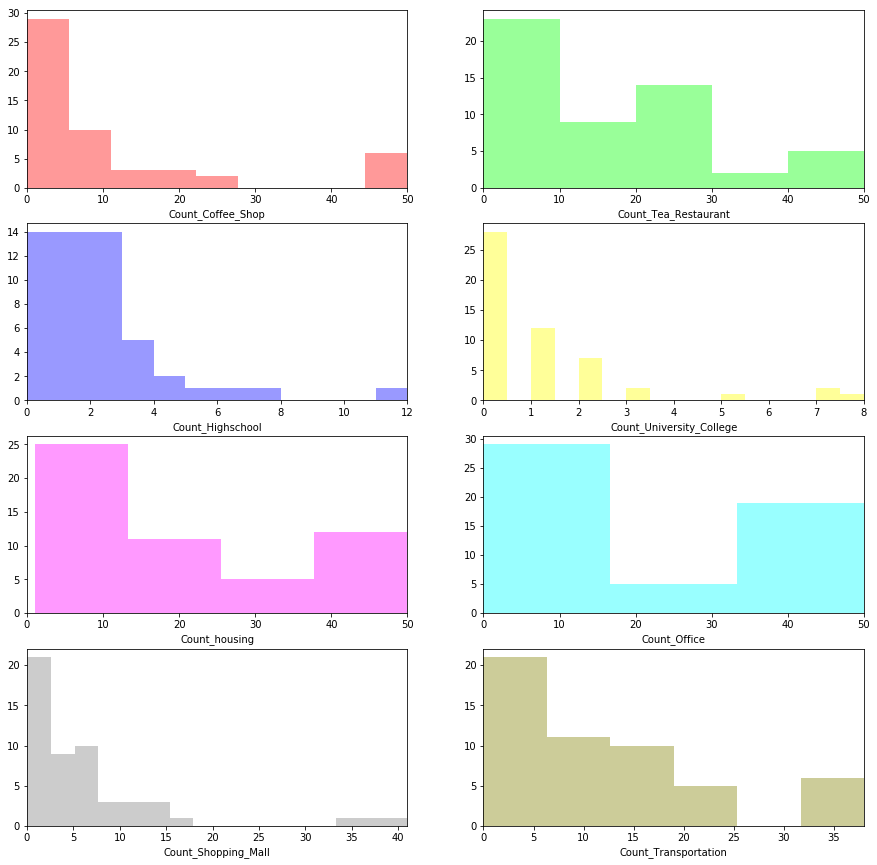

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(4,2,figsize=(15, 15))
sns.distplot(Location_count['Count_Coffee_Shop'], ax=ax[0, 0],color=[1,0,0],kde=False)
sns.distplot(Location_count['Count_Tea_Restaurant'], ax=ax[0, 1],color=[0,1,0],kde=False)
sns.distplot(Location_count['Count_Highschool'], ax=ax[1, 0],color=[0,0,1],kde=False)
sns.distplot(Location_count['Count_University_College'], ax=ax[1, 1],color=[1,1,0],kde=False)
sns.distplot(Location_count['Count_housing'], ax=ax[2, 0],color=[1,0,1],kde=False)
sns.distplot(Location_count['Count_Office'], ax=ax[2, 1],color=[0,1,1],kde=False)
sns.distplot(Location_count['Count_Shopping_Mall'], ax=ax[3, 0],color=[0.5,0.5,0.5],kde=False)
sns.distplot(Location_count['Count_Transportation'], ax=ax[3, 1],color=[0.5,0.5,0],kde=False)
ax[0, 0].set_xlim(0,max(Location_count['Count_Coffee_Shop']))
ax[0, 1].set_xlim(0,max(Location_count['Count_Tea_Restaurant']))
ax[1, 0].set_xlim(0,max(Location_count['Count_Highschool']))
ax[1, 1].set_xlim(0,max(Location_count['Count_University_College']))
ax[2, 0].set_xlim(0,max(Location_count['Count_housing']))
ax[2, 1].set_xlim(0,max(Location_count['Count_Office']))
ax[3, 0].set_xlim(0,max(Location_count['Count_Shopping_Mall']))
ax[3, 1].set_xlim(0,max(Location_count['Count_Transportation']))

plt.show()

The distribution for all variables (category counts) are not normally distributed
<a id='1'></a>

In [280]:
Location_count.describe()

,Count_Coffee_Shop,Count_Tea_Restaurant,Count_Highschool,Count_University_College,Count_housing,Count_Office,Count_Shopping_Mall,Count_Transportation
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,11.094340,16.037736,1.792453,1.113208,21.886792,21.792453,6.622642,12.094340
std,15.013153,15.011486,2.106387,1.857007,17.025615,20.661520,8.696211,10.314784
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,0.000000,7.000000,3.000000,2.000000,4.000000
50%,4.000000,12.000000,1.000000,0.000000,15.000000,11.000000,4.000000,10.000000
75%,12.000000,24.000000,2.000000,1.000000,34.000000,49.000000,7.000000,17.000000
max,50.000000,50.000000,12.000000,8.000000,50.000000,50.000000,41.000000,38.000000


In average, there are 11 coffee shops found in a neighborhood
<a id='2'></a>

In [281]:
Location_count.corr()

,Count_Coffee_Shop,Count_Tea_Restaurant,Count_Highschool,Count_University_College,Count_housing,Count_Office,Count_Shopping_Mall,Count_Transportation
Count_Coffee_Shop,1.000000,0.617004,-0.257210,0.652142,0.618552,0.700245,0.659875,0.874443
Count_Tea_Restaurant,0.617004,1.000000,-0.073338,0.548970,0.620552,0.653658,0.658898,0.788631
Count_Highschool,-0.257210,-0.073338,1.000000,-0.043041,-0.119712,-0.194107,-0.085197,-0.179644
Count_University_College,0.652142,0.548970,-0.043041,1.000000,0.418279,0.408109,0.693383,0.610852
Count_housing,0.618552,0.620552,-0.119712,0.418279,1.000000,0.624457,0.480935,0.687424
Count_Office,0.700245,0.653658,-0.194107,0.408109,0.624457,1.000000,0.496602,0.722333
Count_Shopping_Mall,0.659875,0.658898,-0.085197,0.693383,0.480935,0.496602,1.000000,0.642077
Count_Transportation,0.874443,0.788631,-0.179644,0.610852,0.687424,0.722333,0.642077,1.000000


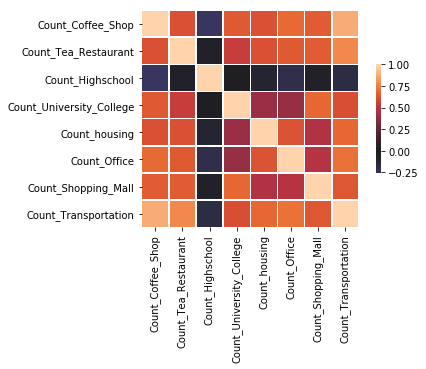

In [282]:
sns.heatmap(Location_count.corr(),   center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the correlation matrix, all variables have high positive correlation with each others except "Count_Highschool". <br>
The heat map clearly shows there is little correlation between the number of high school and number of other categories. (where black colour represents a low correlation coefficient) 

In [283]:
sort_coffeeshop  = Location_count.sort_values(by=['Count_Coffee_Shop'],ascending=False)
sort_coffeeshop.head(10)

,Neighborhood,Count_Coffee_Shop,Count_Tea_Restaurant,Count_Highschool,Count_University_College,Count_housing,Count_Office,Count_Shopping_Mall,Count_Transportation
41,Causeway Bay,50.0,48.0,2.0,2.0,47,50.0,35.0,32.0
42,Admiralty,50.0,24.0,0.0,2.0,23,50.0,13.0,36.0
43,Sheung Wan,50.0,46.0,0.0,3.0,49,50.0,6.0,34.0
44,Central District,50.0,11.0,0.0,5.0,24,50.0,16.0,35.0
0,Tsim Sha Tsui,48.0,38.0,1.0,7.0,50,49.0,41.0,21.0
40,Wan Chai,45.0,50.0,2.0,7.0,50,50.0,11.0,38.0
3,Mongkok,27.0,50.0,1.0,8.0,50,50.0,38.0,34.0
47,Residence Bel-Air,24.0,0.0,0.0,0.0,48,46.0,2.0,16.0
33,Taikoo,20.0,24.0,1.0,0.0,49,50.0,6.0,21.0
34,Quarry Bay,19.0,22.0,1.0,0.0,43,50.0,6.0,19.0


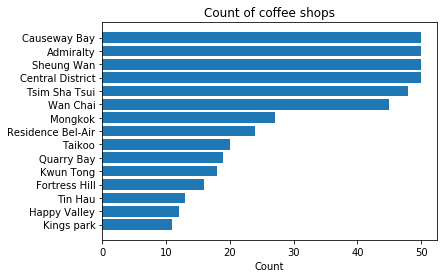

In [284]:
fig, ax = plt.subplots()


y_pos = np.arange(len(sort_coffeeshop['Neighborhood'].head(15)))

ax.barh(y_pos, sort_coffeeshop['Count_Coffee_Shop'].head(15), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(sort_coffeeshop['Neighborhood'].head(15))
ax.invert_yaxis()  
ax.set_xlabel('Count')
ax.set_title('Count of coffee shops')

plt.show()

After sorting the Count_Coffee_Shop values from highest to lowest, a bar chart is plotted to display the first 15 neighborhood.
We can see that Causeway Bay, Admiralty, Sheung Wan, Central District have the highest number coffee shop (Count = 50).

In [285]:
Location_count[Location_count['Count_Coffee_Shop'] <= 5].sort_values(by=['Count_Coffee_Shop'],ascending=False).head(10)

,Neighborhood,Count_Coffee_Shop,Count_Tea_Restaurant,Count_Highschool,Count_University_College,Count_housing,Count_Office,Count_Shopping_Mall,Count_Transportation
18,Wong Tai Sin,5.0,14.0,0.0,1.0,11,10.0,6.0,6.0
9,Sham Shui Po,5.0,50.0,4.0,1.0,28,11.0,13.0,22.0
49,Aberdeen,4.0,12.0,1.0,0.0,7,0.0,6.0,6.0
28,Tseung Kwan O,4.0,3.0,2.0,0.0,9,1.0,9.0,5.0
7,Mei Foo,4.0,8.0,2.0,1.0,2,4.0,2.0,5.0
21,San Po Kong,4.0,22.0,3.0,1.0,10,44.0,6.0,8.0
46,Pokfulam,4.0,1.0,0.0,0.0,5,11.0,2.0,3.0
29,Chai Wan,4.0,9.0,3.0,0.0,7,22.0,4.0,10.0
48,Ap Lei Chau,3.0,4.0,0.0,0.0,8,3.0,3.0,0.0
19,Lok Fu,3.0,2.0,2.0,2.0,7,2.0,3.0,3.0


In [286]:
print ("{} neighborhoods have 5 or less coffee shops found".format(len(Location_count[Location_count['Count_Coffee_Shop'] <= 5].sort_values(by=['Count_Coffee_Shop'],ascending=False))))


29 neighborhoods have 5 or less coffee shops found


## Data preparation

### Clustering different neighborhoods 

Now let's use clustering to group different neighborhoods into five clusters based on venues found in food cateorgies only.

In [287]:
Food = getNearbyVenues(names=Location['Neighborhood'], latitudes=Location['Latitude'], longitudes=Location['Longitude'],  categoryIds=cat_id['Food'])
Food.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tsim Sha Tsui,22.298872,114.174118,Sushi Sooshi (鮨廷),22.299073,114.174072,Sushi Restaurant
1,Tsim Sha Tsui,22.298872,114.174118,Hung Lee Restaurant (洪利粥店茶餐廳),22.299526,114.173891,Cha Chaan Teng
2,Tsim Sha Tsui,22.298872,114.174118,Fairwood (大快活),22.298444,114.173537,Fast Food Restaurant
3,Tsim Sha Tsui,22.298872,114.174118,Canton's Dim Sum Expert (粵廚點心專門店),22.298237,114.172812,Dim Sum Restaurant
4,Tsim Sha Tsui,22.298872,114.174118,Tai Ping Koon Restaurant (太平館餐廳),22.300139,114.174483,Hong Kong Restaurant
5,Tsim Sha Tsui,22.298872,114.174118,McDonald's (麥當勞),22.298743,114.172775,Fast Food Restaurant
6,Tsim Sha Tsui,22.298872,114.174118,Yum Cha (飲茶),22.299942,114.173623,Dim Sum Restaurant
7,Tsim Sha Tsui,22.298872,114.174118,Mammy Pancake (媽咪雞蛋仔),22.298316,114.173523,Snack Place
8,Tsim Sha Tsui,22.298872,114.174118,Tsui Wah Restaurant (翠華餐廳),22.297708,114.172909,Cha Chaan Teng
9,Tsim Sha Tsui,22.298872,114.174118,HEYTEA (喜茶),22.297432,114.173873,Bubble Tea Shop


In [288]:
{
    "tags": [
        "remove_cell",
    ]
}
Food.groupby('Venue Category').count().sort_values(by=['Neighborhood'],ascending=False)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Chinese Restaurant,212,212,212,212,212,212
Coffee Shop,169,169,169,169,169,169
Fast Food Restaurant,167,167,167,167,167,167
Cha Chaan Teng,151,151,151,151,151,151
Café,131,131,131,131,131,131
Noodle House,111,111,111,111,111,111
Japanese Restaurant,107,107,107,107,107,107
Cantonese Restaurant,105,105,105,105,105,105
Hong Kong Restaurant,104,104,104,104,104,104


#### Explore all the venue categories found

In [289]:
Food['Venue Category'].unique()

array(['Sushi Restaurant', 'Cha Chaan Teng', 'Fast Food Restaurant',
       'Dim Sum Restaurant', 'Hong Kong Restaurant', 'Snack Place',
       'Bubble Tea Shop', 'Ice Cream Shop', 'Dessert Shop',
       'Ramen Restaurant', 'Coffee Shop', 'Café', 'Bakery',
       'Dumpling Restaurant', 'Buffet', 'Restaurant', 'Chinese Restaurant',
       'Noodle House', 'Cantonese Restaurant', 'Japanese Restaurant',
       'English Restaurant', 'Steakhouse', 'Pizza Place',
       'Shaanxi Restaurant', 'Malay Restaurant', 'Hotpot Restaurant',
       'Thai Restaurant', 'Supermarket', 'Burger Joint',
       'Italian Restaurant', 'Taiwanese Restaurant',
       'Pakistani Restaurant', 'BBQ Joint', 'Tea Room', 'Sandwich Place',
       'Argentinian Restaurant', 'Seafood Restaurant',
       'Vietnamese Restaurant', 'Shanghai Restaurant', 'French Restaurant',
       'Vegetarian / Vegan Restaurant', 'Donburi Restaurant',
       'Satay Restaurant', 'General Entertainment', 'Fried Chicken Joint',
       'Diner', '

In [290]:
print('There are {} uniques categories.'.format(len(Food['Venue Category'].unique())))

There are 114 uniques categories.


#### Use one hot encoding to convert the categorical data to numbers so that they can be used in clustering algorithm 

In [291]:
# one hot encoding
HK_food_onehot = pd.get_dummies(Food[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
HK_food_onehot['Neighborhood'] = Food['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [HK_food_onehot.columns[-1]] + list(HK_food_onehot.columns[:-1])
HK_food_onehot = HK_food_onehot[fixed_columns]

HK_food_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Balinese Restaurant,Bar,Beer Bar,Beijing Restaurant,Belgian Restaurant,Bistro,Breakfast Spot,Bubble Tea Shop,Buffet,Burger Joint,Cafeteria,Café,Cantonese Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Donburi Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Fujian Restaurant,Furniture / Home Store,Gastropub,General Entertainment,German Restaurant,Hainan Restaurant,Halal Restaurant,Health Food Store,Hong Kong Restaurant,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lounge,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,New American Restaurant,Noodle House,Pakistani Restaurant,Pastry Shop,Peruvian Restaurant,Pizza Place,Pub,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Salad Place,Sandwich Place,Satay Restaurant,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shandong Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Social Club,Soup Place,Spanish Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Takoyaki Place,Tea Room,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yunnan Restaurant
0,Tsim Sha Tsui,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Tsim Sha Tsui,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Tsim Sha Tsui,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Tsim Sha Tsui,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Tsim Sha Tsui,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [292]:
{
    "tags": [
        "remove_cell",
    ]
}
HK_food_onehot.shape

(2422, 115)

In [293]:
{
    "tags": [
        "remove_cell",
    ]
}
HK_food_grouped = HK_food_onehot.groupby('Neighborhood').mean().reset_index()
HK_food_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Balinese Restaurant,Bar,Beer Bar,Beijing Restaurant,Belgian Restaurant,Bistro,Breakfast Spot,Bubble Tea Shop,Buffet,Burger Joint,Cafeteria,Café,Cantonese Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Donburi Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Fujian Restaurant,Furniture / Home Store,Gastropub,General Entertainment,German Restaurant,Hainan Restaurant,Halal Restaurant,Health Food Store,Hong Kong Restaurant,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lounge,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,New American Restaurant,Noodle House,Pakistani Restaurant,Pastry Shop,Peruvian Restaurant,Pizza Place,Pub,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Salad Place,Sandwich Place,Satay Restaurant,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shandong Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Social Club,Soup Place,Spanish Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Takoyaki Place,Tea Room,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yunnan Restaurant
0,Aberdeen,0.00,0.00,0.000000,0.00,0.040000,0.000000,0.000000,0.020000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.020000,0.040000,0.060000,0.00,0.160000,0.00,0.060000,0.000000,0.02000,0.00,0.000000,0.020000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.020000,0.000000,0.00,0.00,0.080000,0.00,0.020000,0.000000,0.000000,0.00,0.02,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.020000,0.00,0.00,0.00,0.00,0.020000,0.02000,0.000000,0.000000,0.040000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.040000,0.00,0.00,0.00,0.040000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.040000,0.00,0.020000,0.00,0.060000,0.020000,0.00,0.00,0.000000,0.00,0.00000,0.00,0.040000,0.00,0.020000,0.00,0.020000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.020000,0.00,0.00
1,Admiralty,0.00,0.00,0.000000,0.00,0.020000,0.000000,0.000000,0.020000,0.000000,0.00,0.00,0.02,0.00,0.000000,0.00,0.000000,0.00,0.02,0.000000,0.040000,0.040000,0.060000,0.00,0.040000,0.00,0.220000,0.000000,0.00000,0.00,0.020000,0.000000,0.060000,0.000000,0.00,0.020000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.020000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.040000,0.00,0.00,0.00,0.00,0.000000,0.00000,0.060000,0.000000,0.040000,0.000000,0.00,0.000000,0.00,0.000000,0.02,0.00,0.00,0.00,0.00,0.060000,0.00,0.00,0.02,0.000000,0.00,0.040000,0.00,0.020000,0.02,0.020000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.02,0.000000,0.02,0.00000,0.00,0.020000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00
2,Ap Lei Chau,0.00,0.00,0.000000,0.00,0.040000,0.000000,0.040000,0.020000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.02,0.000000,0.040000,0.040000,0.020000,0.00,0.200000,0.00,0.040000,0.000000,0.00000,0.02,0.000000,0.040000,0.020000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.060000,0.00,0.020000,0.000000,0.000000,0.02,0.02,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.020000,0.00,0.00,0.00,0.00,0.000000,0.00000,0.020000,0.000000,0.000000,0.000000

#### Calculate the first 5 common venues in each neighborhood

In [294]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [295]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = HK_food_grouped['Neighborhood']

for ind in np.arange(HK_food_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(HK_food_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aberdeen,Chinese Restaurant,Fast Food Restaurant,Shanghai Restaurant,Cha Chaan Teng,Coffee Shop
1,Admiralty,Coffee Shop,Italian Restaurant,Dim Sum Restaurant,Noodle House,Cha Chaan Teng
2,Ap Lei Chau,Chinese Restaurant,Fast Food Restaurant,Thai Restaurant,Cantonese Restaurant,Coffee Shop
3,Beacon Hill,Diner,Coffee Shop,Chinese Restaurant,Korean Restaurant,Cantonese Restaurant
4,Braemar Hill,Fast Food Restaurant,Cha Chaan Teng,Japanese Restaurant,Coffee Shop,Café


## Modelling

In [296]:
# set number of clusters
kclusters = 5

HK_food_grouped_clustering = HK_food_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(HK_food_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 4, 3, 0, 0, 4, 4, 1, 1, 1], dtype=int32)

In [297]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#### Display the cluster labels assigned to each neighborhood

In [298]:
{
    "tags": [
        "remove_input",
    ]
}
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,3,Aberdeen,Chinese Restaurant,Fast Food Restaurant,Shanghai Restaurant,Cha Chaan Teng,Coffee Shop
1,4,Admiralty,Coffee Shop,Italian Restaurant,Dim Sum Restaurant,Noodle House,Cha Chaan Teng
2,3,Ap Lei Chau,Chinese Restaurant,Fast Food Restaurant,Thai Restaurant,Cantonese Restaurant,Coffee Shop
3,0,Beacon Hill,Diner,Coffee Shop,Chinese Restaurant,Korean Restaurant,Cantonese Restaurant
4,0,Braemar Hill,Fast Food Restaurant,Cha Chaan Teng,Japanese Restaurant,Coffee Shop,Café
5,4,Causeway Bay,Coffee Shop,Noodle House,Cha Chaan Teng,Fast Food Restaurant,Chinese Restaurant
6,4,Central District,Coffee Shop,Italian Restaurant,Café,Noodle House,Fast Food Restaurant
7,1,Chai Wan,Fast Food Restaurant,Cha Chaan Teng,Chinese Restaurant,Snack Place,Cantonese Restaurant
8,1,Cheung Sha Wan,Cha Chaan Teng,Fast Food Restaurant,Hong Kong Restaurant,Dim Sum Restaurant,Chinese Restaurant
9,1,Diamond Hill,Fast Food Restaurant,Cha Chaan Teng,Japanese Restaurant,Dessert Shop,Vietnamese Restaurant


#### Plot the neighborhoods on map with different colour

In [299]:
{
    "tags": [
        "remove_cell",
    ]
}
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

HK_food_merged = Location

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
HK_food_merged = HK_food_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

HK_food_merged['Cluster Labels'] = HK_food_merged['Cluster Labels'].fillna(0)
HK_food_merged['Cluster Labels'] = HK_food_merged['Cluster Labels'].astype('int64', copy=False)


HK_food_merged.head() # check the last columns!

,Neighborhood,District,Latitude,Longitude,searching,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Tsim Sha Tsui,Kowloon,22.298872,114.174118,Tsim Sha Tsui Kowloon,4,Coffee Shop,Cha Chaan Teng,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant
1,Yau Ma Tei,Kowloon,22.306938,114.164463,Yau Ma Tei Kowloon,3,Chinese Restaurant,Cantonese Restaurant,Coffee Shop,Café,Bakery
2,Kings park,Kowloon,22.310572,114.174299,Kings park Kowloon,1,Hong Kong Restaurant,Cantonese Restaurant,Fast Food Restaurant,Chinese Restaurant,Coffee Shop
3,Mongkok,Kowloon,22.319685,114.168397,Mongkok Kowloon,4,Coffee Shop,Fast Food Restaurant,Bubble Tea Shop,Chinese Restaurant,Cha Chaan Teng
4,Tai Kok Tsui,Kowloon,22.321068,114.161210,Tai Kok Tsui Kowloon,0,Fast Food Restaurant,Japanese Restaurant,Coffee Shop,Noodle House,Cha Chaan Teng


In [300]:
{
    "tags": [
        "remove_cell",
    ]
}
import matplotlib.cm as cm
import matplotlib.colors as colors

In [309]:
{
    "tags": [
        "remove_cell",
    ]
}
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))

In [302]:
{
    "tags": [
        "remove_input",
    ]
}
# create map
map_clusters = folium.Map(location=[Location['Latitude'].mean(),Location['Longitude'].mean()], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(HK_food_merged['Latitude'], HK_food_merged['Longitude'], HK_food_merged['Neighborhood'], HK_food_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='3'></a>
#### Explore the common food venues in each cluster in detail for each cluster

_Cluster 0_

In [310]:
HK_food_merged.loc[HK_food_merged['Cluster Labels'] == 0, HK_food_merged.columns[[0] + list(range(5, HK_food_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Tai Kok Tsui,0,Fast Food Restaurant,Japanese Restaurant,Coffee Shop,Noodle House,Cha Chaan Teng
5,Olympic,0,Fast Food Restaurant,Japanese Restaurant,Coffee Shop,Chinese Restaurant,Café
12,Beacon Hill,0,Diner,Coffee Shop,Chinese Restaurant,Korean Restaurant,Cantonese Restaurant
14,Hung Hom,0,Fast Food Restaurant,Japanese Restaurant,Hong Kong Restaurant,Noodle House,Chinese Restaurant
16,Kai Tak,0,Chinese Restaurant,Fast Food Restaurant,Café,Cantonese Restaurant,Japanese Restaurant
17,Kowloon City,0,Thai Restaurant,Dessert Shop,Café,Bakery,Coffee Shop
24,Kwun Tong,0,Japanese Restaurant,Cha Chaan Teng,Coffee Shop,Fast Food Restaurant,Noodle House
26,Yau Tong Station,0,Café,Bakery,Chinese Restaurant,Fast Food Restaurant,Japanese Restaurant
30,Heng Fa Chuen,0,Bakery,Café,Cantonese Restaurant,Asian Restaurant,Ramen Restaurant
33,Taikoo,0,Cantonese Restaurant,Café,Japanese Restaurant,Fast Food Restaurant,Cha Chaan Teng


_Cluster 1_

In [311]:
HK_food_merged.loc[HK_food_merged['Cluster Labels'] == 1, HK_food_merged.columns[[0] + list(range(5, HK_food_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Kings park,1,Hong Kong Restaurant,Cantonese Restaurant,Fast Food Restaurant,Chinese Restaurant,Coffee Shop
7,Mei Foo,1,Chinese Restaurant,Cha Chaan Teng,Bakery,Fast Food Restaurant,Japanese Restaurant
8,Cheung Sha Wan,1,Cha Chaan Teng,Fast Food Restaurant,Hong Kong Restaurant,Dim Sum Restaurant,Chinese Restaurant
9,Sham Shui Po,1,Noodle House,Cha Chaan Teng,Dessert Shop,Hong Kong Restaurant,Fast Food Restaurant
15,To Kwa Wan,1,Hong Kong Restaurant,Chinese Restaurant,Cha Chaan Teng,Noodle House,Café
18,Wong Tai Sin,1,Cantonese Restaurant,Chinese Restaurant,Hong Kong Restaurant,Noodle House,Coffee Shop
20,Diamond Hill,1,Fast Food Restaurant,Cha Chaan Teng,Japanese Restaurant,Dessert Shop,Vietnamese Restaurant
21,San Po Kong,1,Chinese Restaurant,Cha Chaan Teng,Bakery,Fast Food Restaurant,Japanese Restaurant
23,Kowloon Bay,1,Noodle House,Hong Kong Restaurant,Cha Chaan Teng,Chinese Restaurant,Café
25,Lam Tin,1,Chinese Restaurant,Fast Food Restaurant,Noodle House,Hong Kong Restaurant,Cha Chaan Teng


_Cluster 2_

In [312]:
HK_food_merged.loc[HK_food_merged['Cluster Labels'] == 2, HK_food_merged.columns[[0] + list(range(5, HK_food_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
22,Ngau Chi Wan,2,Fast Food Restaurant,Restaurant,Deli / Bodega,Dessert Shop,Dim Sum Restaurant


_Cluster 3_

In [313]:
HK_food_merged.loc[HK_food_merged['Cluster Labels'] == 3, HK_food_merged.columns[[0] + list(range(5, HK_food_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Yau Ma Tei,3,Chinese Restaurant,Cantonese Restaurant,Coffee Shop,Café,Bakery
6,Lai Chi Kok,3,Chinese Restaurant,Japanese Restaurant,Cantonese Restaurant,Cha Chaan Teng,Café
10,Yau Yat Chuen,3,Chinese Restaurant,Café,Fast Food Restaurant,Hong Kong Restaurant,Japanese Restaurant
11,Kowloon Tong,3,Chinese Restaurant,Hong Kong Restaurant,Tea Room,Fast Food Restaurant,Dessert Shop
13,Ho Man Tin,3,Chinese Restaurant,Café,Snack Place,Diner,Asian Restaurant
19,Lok Fu,3,Chinese Restaurant,Café,Coffee Shop,Fast Food Restaurant,Pizza Place
28,Tseung Kwan O,3,Café,Chinese Restaurant,Vietnamese Restaurant,Dessert Shop,Hong Kong Restaurant
39,Happy Valley,3,Chinese Restaurant,Coffee Shop,Hong Kong Restaurant,Japanese Restaurant,French Restaurant
48,Ap Lei Chau,3,Chinese Restaurant,Fast Food Restaurant,Thai Restaurant,Cantonese Restaurant,Coffee Shop
49,Aberdeen,3,Chinese Restaurant,Fast Food Restaurant,Shanghai Restaurant,Cha Chaan Teng,Coffee Shop


_Cluster 4_

In [314]:
HK_food_merged.loc[HK_food_merged['Cluster Labels'] == 4, HK_food_merged.columns[[0] + list(range(5, HK_food_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Tsim Sha Tsui,4,Coffee Shop,Cha Chaan Teng,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant
3,Mongkok,4,Coffee Shop,Fast Food Restaurant,Bubble Tea Shop,Chinese Restaurant,Cha Chaan Teng
38,Tin Hau,4,Coffee Shop,Noodle House,Chinese Restaurant,Fast Food Restaurant,Japanese Restaurant
40,Wan Chai,4,Coffee Shop,Italian Restaurant,Café,Fast Food Restaurant,Cantonese Restaurant
41,Causeway Bay,4,Coffee Shop,Noodle House,Cha Chaan Teng,Fast Food Restaurant,Chinese Restaurant
42,Admiralty,4,Coffee Shop,Italian Restaurant,Dim Sum Restaurant,Noodle House,Cha Chaan Teng
43,Sheung Wan,4,Coffee Shop,Cha Chaan Teng,Chinese Restaurant,Fast Food Restaurant,Café
44,Central District,4,Coffee Shop,Italian Restaurant,Café,Noodle House,Fast Food Restaurant
46,Pokfulam,4,Coffee Shop,Asian Restaurant,Chinese Restaurant,Bakery,Fast Food Restaurant
47,Residence Bel-Air,4,Chinese Restaurant,Coffee Shop,Pizza Place,Filipino Restaurant,Korean Restaurant


#### The five clusters are:
Cluster 1: Japanese Restaurant, Fast Food Restaurant <br>
Cluster 2: Cha Chaan Ten (tea restaurant) and Hong Kong Restaurant. <br>
Cluster 3: Fast Food Restaurant <br>
Cluster 4: Chinese Restaurant <br>
Cluster 5: Coffee Shop <br>

## Result
For people who want to operate a new business (e.g. coffee shop), the analysis brings useful information to them and their decision. <br>
However, the decision really depends on different interpretation.

[descriptive statistics](#1) <br>
From the descriptive statistics, we can know which neighbourhoods have the most/ the least number of coffee shop. <br>
1. Will large number of coffee shop in the same neighbourhood increase the competition? <br>
If yes, we may suggest not to open new coffee shop in that neighbourhood.   <br>
We suggest to open in neighbourhood that have little number of existing coffee shops like Wong Tai Sin and San Po Kong.	 <br>
2. Are there some special reasons or advantages for so many coffee shops operated in that neighbourhood? <br>
If yes, we may thing it would be an advantage to open new coffee shop in neighbourhood that have large number of existing coffee shops <br>

[correlation](#2)  <br>
From the correlation matrix, we can know the number of some facilities have correlation with the number of coffee shop. <br> 
We can see all variables examinated have high positive correlation with each others except "Count_Highschool". <br>
For example, 0.700245 for the Count_office/Count_coffee_shop pair suggests there is an linear relationship between the number of office and coffee shop.  <br>
That means in a neighbourhood with more offices we can possibly find more coffee shops or vice versa. <br>
These pairs may exist or not a causal relationship. 
For example: 
1. Office -  attracting business executives and workers as customers
2. Colleges or universities - attracting students as customers
3. Residential buildings, attracting the general public living in that place as customers <br>
If we assume the causal relationship exist, we suggest finding neighbourhoods that have more number of offices, colleges, residential buildings, shopping mall, transportations like 
Mongkok, Taikoo, Quarry Bay.

[clustering result](#3)  <br>
From clustering, we can know how the neighbourhoods are segmented according to the restaurant type. In cluster 5, coffee shop is the most common place. <br> Apparently, it matches with our results in descriptive statistics part and correlation part. <br>
We can easily find that neighbourhoods in cluster 5 have higher number of coffee shops and they have higher number of offices, residential buildings, transportations,etc.  <br>
When it comes to the decision of which neighbourhoods should be chosen, we need to do further analyst on the above issues. 

In [315]:
{
    "tags": [
        "remove_input",
    ]
}
print("Neighborhoods in cluster 4")
sort_coffeeshop[sort_coffeeshop.Neighborhood.isin(HK_food_merged.loc[HK_food_merged['Cluster Labels'] == 4,"Neighborhood"])]

Neighborhoods in cluster 4


,Neighborhood,Count_Coffee_Shop,Count_Tea_Restaurant,Count_Highschool,Count_University_College,Count_housing,Count_Office,Count_Shopping_Mall,Count_Transportation
41,Causeway Bay,50.0,48.0,2.0,2.0,47,50.0,35.0,32.0
42,Admiralty,50.0,24.0,0.0,2.0,23,50.0,13.0,36.0
43,Sheung Wan,50.0,46.0,0.0,3.0,49,50.0,6.0,34.0
44,Central District,50.0,11.0,0.0,5.0,24,50.0,16.0,35.0
0,Tsim Sha Tsui,48.0,38.0,1.0,7.0,50,49.0,41.0,21.0
40,Wan Chai,45.0,50.0,2.0,7.0,50,50.0,11.0,38.0
3,Mongkok,27.0,50.0,1.0,8.0,50,50.0,38.0,34.0
47,Residence Bel-Air,24.0,0.0,0.0,0.0,48,46.0,2.0,16.0
38,Tin Hau,13.0,23.0,2.0,0.0,50,50.0,2.0,17.0
46,Pokfulam,4.0,1.0,0.0,0.0,5,11.0,2.0,3.0


### Conclusion and Discussion

The above analysis use foursquare API to search venues for different categories. <br>
We have use descriptive statistics, different plottings, and  clustering to understand the market. <br>
We can now have a clear picture of catering industry in different neighbourhoods in Hong Kong. <br>


Below are some limitations or improvements we can make  <br>
1.
[neighbourhood names](#5) <br>
The neighbourhood names are scrapped from real estate company website, it does not cover all neighbourhoods in Hong Kong. With more or less neighbourhoods added, the result may have small difference. <br>
Nominatim returns wrong coodinates or even fails for some neighbourhoods due to similar names of neighbourhoods. If more time and resource are allowed, different neighbourhoods names or other libraries should be tried to compare the search result.

2.
[venue count](#4) <br>
The Foursquare API has a result limit of 50 for venue search. For common categories like coffee shop, tea resturant and residence place, many neighbourhoods have reached the 50 result limit. In fact, the should be more results (>50). This affacts the ranking for neighbourhoods, calculation of correlation, and the clustering results, etc.  

3.
[distributions plot](#6) <br>
For the distributions plot, we can see that the venue counts for all categories are not normally distributed. 
For university/college and high school, the distributions of venue counts are skewed to right. For other categories, it reflects an interesting feature that there are either a large number of venues or almost no venue found in these neighbourhoods. These big differences may be because of the unique characteristics of each neighbourhood in Hong Kong: Some neighbourhoods are considered as "residential areas like "Happy Valley" and some are considered as commercial areas like "Admiralty".  In the future, we can first cluster different Hong Kong neighbourhoods based on the neighbourhoods characterisitics, then within each cluster, we can further cluster based on the food category. It may help produce a more accurate result if we want to do analysis to neighbourhoods in some specific areas.
